
# 🇮🇩 Address NER with IndoBERT — End‑to‑End Notebook

Notebook ini membangun model **NER (BIO)** untuk parsing alamat Indonesia menggunakan **Hugging Face** dan **`indobenchmark/indobert-base-p1`**.

**Rangka:**
1. **Data Preprocessing** — load, validasi, EDA (statistik deskriptif).
2. **Splitting Data** — pembagian train/valid/test yang stabil dan representatif.
3. **Data Processing & Training** — tokenisasi, label alignment, training dengan `Trainer`, simpan model.
4. **Evaluation & Visualization** — metrik `seqeval`, grafik training loss & F1, laporan ringkas.

> Catatan: pastikan file dataset JSON kamu (hasil generator) tersedia. Notebook akan mencari otomatis beberapa nama file umum.


In [1]:

# %%capture
# Jika menjalankan di lingkungan baru (Colab/venv), uncomment baris berikut:
# !pip install -q transformers datasets seqeval accelerate matplotlib

import os, json, random, math, collections
from typing import List, Dict
import numpy as np

import matplotlib.pyplot as plt

from datasets import Dataset, DatasetDict
from transformers import (AutoTokenizer, AutoModelForTokenClassification, DataCollatorForTokenClassification,
                          TrainingArguments, Trainer, EarlyStoppingCallback)
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score
from seqeval.scheme import IOB2

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

MODEL_NAME = "indobenchmark/indobert-base-p1"


## 1) Data Preprocessing — Load, Validasi, dan EDA

Loaded file: ../dataset/alamat_dataset_aug_third.json — 3000 rows

Statistik dasar:
- Jumlah contoh: 3000
- Rata-rata panjang token: 11.64 ± 5.31
- Min/Max panjang token: 2 / 29

10 label teratas:
I-JALAN      : 5116
O            : 3837
B-JALAN      : 3006
B-KOTA       : 2154
B-PROVINSI   : 2113
I-KELURAHAN  : 1970
B-KELURAHAN  : 1959
B-KECAMATAN  : 1941
I-PROVINSI   : 1918
I-KECAMATAN  : 1845


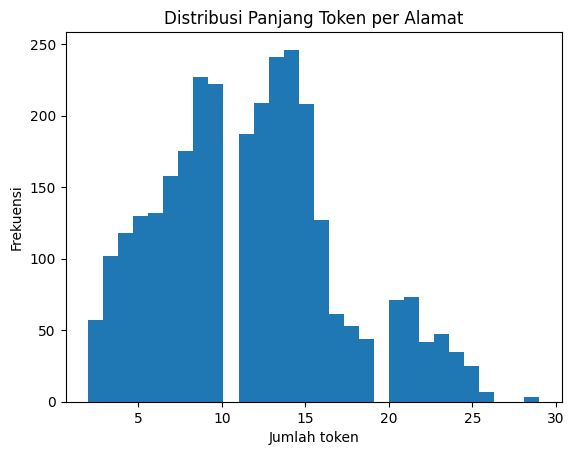


Komponen alamat (jumlah & proporsi):
- RT: 1628 (54.3%) | RW: 1623 (54.1%)
- Kelurahan: 1959 (65.3%) | Kecamatan: 1940 (64.7%)
- Kota: 2152 (71.7%) | Provinsi: 2113 (70.4%)
- Kodepos: 1313 (43.8%)


In [2]:

# Cari file dataset secara otomatis
CANDIDATE_FILES = [
    "../dataset/alamat_dataset_aug_third.json",  # Lokasi di repo GitHub
]

data_path = None
for f in CANDIDATE_FILES:
    if os.path.exists(f):
        data_path = f
        break

if data_path is None:
    # Fallback: buat contoh mini jika file tidak ditemukan
    data_path = "mini_sample.json"
    mini = [
        {"id": 1, "token": ["Jl.", "Diponegoro", "No.15", ",", "Kel.", "Menteng", ",", "Kec.", "Menteng", ",", "Kota", "Jakarta", "Pusat", ",", "DKI", "Jakarta"], 
         "labels": ["B-JALAN","I-JALAN","I-JALAN","O","B-KELURAHAN","I-KELURAHAN","O","B-KECAMATAN","I-KECAMATAN","O","B-KOTA","I-KOTA","I-KOTA","O","B-PROVINSI","I-PROVINSI"]},
        {"id": 2, "token": ["Gg.", "Mawar", "No.7", "RT.", "01", "/", "RW.", "02", ",", "Kel.", "Sukajadi", ",", "Kec.", "Sukajadi", ",", "Kota", "Pekanbaru", ",", "Riau"], 
         "labels": ["B-JALAN","I-JALAN","I-JALAN","B-RT","I-RT","O","B-RW","I-RW","O","B-KELURAHAN","I-KELURAHAN","O","B-KECAMATAN","I-KECAMATAN","O","B-KOTA","I-KOTA","B-PROVINSI"]}
    ]
    with open(data_path, "w", encoding="utf8") as f:
        json.dump(mini, f, ensure_ascii=False, indent=2)

with open(data_path, "r", encoding="utf8") as f:
    raw_data = json.load(f)

print(f"Loaded file: {data_path} — {len(raw_data)} rows")

# Validasi struktur minimal
assert all(isinstance(r, dict) and "token" in r and "labels" in r for r in raw_data)

# EDA ringkas
num_examples = len(raw_data)
token_lens = [len(r["token"]) for r in raw_data]
label_counts = collections.Counter([lab for r in raw_data for lab in r["labels"]])
entity_spans = collections.Counter([lab.split('-')[-1] for lab in label_counts if lab != "O"])

print("\nStatistik dasar:")
print(f"- Jumlah contoh: {num_examples}")
print(f"- Rata-rata panjang token: {np.mean(token_lens):.2f} ± {np.std(token_lens):.2f}")
print(f"- Min/Max panjang token: {np.min(token_lens)} / {np.max(token_lens)}")

print("\n10 label teratas:")
for k, v in label_counts.most_common(10):
    print(f"{k:<12} : {v}")

# Visualisasi panjang sequence
plt.figure()
plt.hist(token_lens, bins=30)
plt.title("Distribusi Panjang Token per Alamat")
plt.xlabel("Jumlah token")
plt.ylabel("Frekuensi")
plt.show()

# Info khusus: proporsi yang memiliki RT/RW, Kel/KeC, Kota, Prov
def has_any(labels: List[str], prefix: str) -> bool:
    return any(l.startswith(prefix) for l in labels)

has_rt = sum(has_any(r["labels"], "B-RT") for r in raw_data)
has_rw = sum(has_any(r["labels"], "B-RW") for r in raw_data)
has_kel = sum(has_any(r["labels"], "B-KELURAHAN") for r in raw_data)
has_kec = sum(has_any(r["labels"], "B-KECAMATAN") for r in raw_data)
has_kota = sum(has_any(r["labels"], "B-KOTA") for r in raw_data)
has_prov = sum(has_any(r["labels"], "B-PROVINSI") for r in raw_data)
has_kodepos = sum(has_any(r["labels"], "B-KODEPOS") for r in raw_data)

print("\nKomponen alamat (jumlah & proporsi):")
print(f"- RT: {has_rt} ({has_rt/num_examples:.1%}) | RW: {has_rw} ({has_rw/num_examples:.1%})")
print(f"- Kelurahan: {has_kel} ({has_kel/num_examples:.1%}) | Kecamatan: {has_kec} ({has_kec/num_examples:.1%})")
print(f"- Kota: {has_kota} ({has_kota/num_examples:.1%}) | Provinsi: {has_prov} ({has_prov/num_examples:.1%})")
print(f"- Kodepos: {has_kodepos} ({has_kodepos/num_examples:.1%})")



## 2) Splitting Data — Train/Validation/Test

Strategi: **80/10/10** dengan seed tetap agar reprodusibel. Untuk NER, stratifikasi sempurna sulit (karena sekuens), 
tapi kita jaga **distribusi panjang** dan keberadaan komponen alamat tetap mirip antar split dengan **shuffling terkontrol**.


In [3]:
for i, row in enumerate(raw_data):
    if len(row["token"]) != len(row["labels"]):
        print(f"Mismatch at id={row.get('id', i)}: tokens={len(row['token'])}, labels={len(row['labels'])}")


In [4]:

# Shuffle dengan seed tetap
idx = list(range(len(raw_data)))
random.shuffle(idx)

train_end = int(0.8 * len(idx))
val_end = int(0.9 * len(idx))

train_idx = idx[:train_end]
val_idx = idx[train_end:val_end]
test_idx = idx[val_end:]

def select(data, indices):
    return [data[i] for i in indices]

train_data = select(raw_data, train_idx)
val_data = select(raw_data, val_idx)
test_data = select(raw_data, test_idx)

print(f"Split sizes -> train: {len(train_data)}, val: {len(val_data)}, test: {len(test_data)}")


Split sizes -> train: 2400, val: 300, test: 300



## 3) Data Processing & Training (Hugging Face)

- Tokenizer/model: **`indobenchmark/indobert-base-p1`**
- Batch size: 16 (ubah jika GPU/VRAM terbatas)
- LR: 2e-5
- **Epochs rekomendasi**: `6` dengan **early stopping (patience=2)** → mencegah overfitting pada 1200 data.
- Simpan model terbaik berdasarkan `eval_f1`.


In [5]:

# Siapkan label set dan mapping
all_labels = sorted(list(set(l for r in raw_data for l in r["labels"])))
# Pastikan konsistensi skema BIO
if "O" in all_labels:
    # biarkan O paling awal hanya untuk kenyamanan display (opsional)
    all_labels.remove("O")
    all_labels = ["O"] + all_labels

label2id = {l:i for i,l in enumerate(all_labels)}
id2label = {i:l for l,i in label2id.items()}

print("Labels:", all_labels)
print("num_labels:", len(all_labels))

# Helper: convert list-of-dicts to HF Dataset
def to_hf_dataset(rows):
    return Dataset.from_dict({
        "id": [r.get("id", -1) for r in rows],
        "tokens": [r["token"] for r in rows],
        "ner_tags": [[label2id[l] for l in r["labels"]] for r in rows],
    })

ds = DatasetDict({
    "train": to_hf_dataset(train_data),
    "validation": to_hf_dataset(val_data),
    "test": to_hf_dataset(test_data),
})

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Align labels dengan wordpiece tokenizer
def tokenize_and_align_labels(examples):
    tokenized = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    aligned_labels = []
    for i, labels in enumerate(examples["ner_tags"]):
        word_ids = tokenized.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)  # diabaikan loss
            elif word_idx != previous_word_idx:
                label_ids.append(labels[word_idx])
            else:
                # untuk subword lanjutan → gunakan skema I-*
                lab_id = labels[word_idx]
                lab = id2label[lab_id]
                if lab == "O":
                    label_ids.append(lab_id)
                else:
                    # paksa ke I- untuk subword lanjutan
                    ent = lab.split("-", 1)[-1]
                    label_ids.append(label2id.get("I-" + ent, lab_id))
            previous_word_idx = word_idx
        aligned_labels.append(label_ids)
    tokenized["labels"] = aligned_labels
    return tokenized

tokenized_ds = ds.map(tokenize_and_align_labels, batched=True)

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(all_labels),
    id2label=id2label,
    label2id=label2id
)

metric_best = "f1"

args = TrainingArguments(
    output_dir="indoaddr_ner_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=16,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_best,
    report_to="none",
    seed=RANDOM_SEED,
    logging_steps=50
)

# Metrik seqeval
def compute_metrics(p):
    preds, labels = p
    preds = np.argmax(preds, axis=2)
    true_predictions = []
    true_labels = []
    for pred, lab in zip(preds, labels):
        curr_pred = []
        curr_lab = []
        for p_i, l_i in zip(pred, lab):
            if l_i == -100:
                continue
            curr_pred.append(id2label[p_i])
            curr_lab.append(id2label[l_i])
        true_predictions.append(curr_pred)
        true_labels.append(curr_lab)

    f1 = f1_score(true_labels, true_predictions, scheme=IOB2)
    prec = precision_score(true_labels, true_predictions, scheme=IOB2)
    rec = recall_score(true_labels, true_predictions, scheme=IOB2)
    return {"precision": prec, "recall": rec, "f1": f1}

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

train_result = trainer.train()
trainer.save_model("model12/best")  # simpan model terbaik
tokenizer.save_pretrained("model12/best")
print("Model saved to: model10/best")


Labels: ['O', 'B-JALAN', 'B-KECAMATAN', 'B-KELURAHAN', 'B-KODEPOS', 'B-KOTA', 'B-PROVINSI', 'B-RT', 'B-RW', 'I-JALAN', 'I-KECAMATAN', 'I-KELURAHAN', 'I-KOTA', 'I-PROVINSI', 'I-RT', 'I-RW']
num_labels: 16


Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/68/clbgzjwd7vgfrhngp67ysmqc0000gn/T/ipykernel_7768/932101425.py:109: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/nusanet/Documents/addressParser/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.033900,0.098760,0.967269,0.973864,0.970555
2,0.008600,0.096732,0.971203,0.977273,0.974228
3,0.007200,0.086765,0.975679,0.980114,0.977891
4,0.002700,0.101439,0.975706,0.981250,0.978470
5,0.002100,0.088355,0.983551,0.985227,0.984388
6,0.001600,0.090189,0.981849,0.983523,0.982685
7,0.000600,0.092159,0.981859,0.984091,0.982974


/Users/nusanet/Documents/addressParser/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/nusanet/Documents/addressParser/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/nusanet/Documents/addressParser/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/nusanet/Documents/addressParser/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used

Model saved to: model10/best



## 4) Evaluation & Visualization

Kita evaluasi di **test set** dan tampilkan:
- **Classification report** (precision / recall / F1 per label)
- **Grafik training & eval loss per epoch**
- **Grafik F1 validasi per epoch**


/Users/nusanet/Documents/addressParser/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Test metrics: {'eval_loss': 0.015611117705702782, 'eval_precision': 0.9926470588235294, 'eval_recall': 0.9937712344280861, 'eval_f1': 0.9932088285229203, 'eval_runtime': 2.0284, 'eval_samples_per_second': 147.901, 'eval_steps_per_second': 9.367, 'epoch': 7.0}

Classification Report (seqeval):
              precision    recall  f1-score   support

       JALAN       1.00      1.00      1.00       300
   KECAMATAN       0.97      0.99      0.98       192
   KELURAHAN       0.98      0.97      0.98       200
     KODEPOS       1.00      0.99      1.00       334
        KOTA       1.00      1.00      1.00       212
    PROVINSI       1.00      1.00      1.00       210
          RT       0.99      0.99      0.99       159
          RW       1.00      0.99      1.00       159

   micro avg       0.99      0.99      0.99      1766
   macro avg       0.99      0.99      0.99      1766
weighted avg       0.99      0.99      0.99      1766



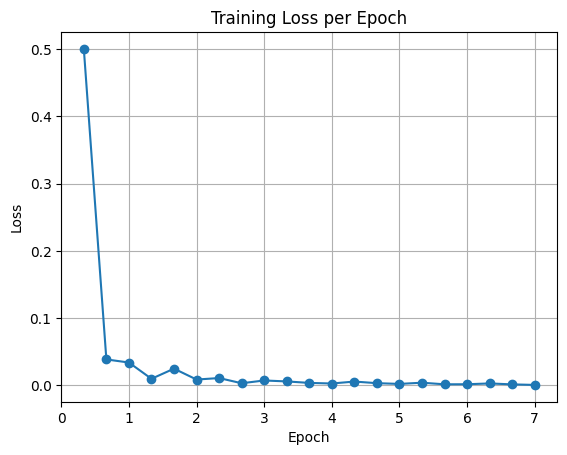

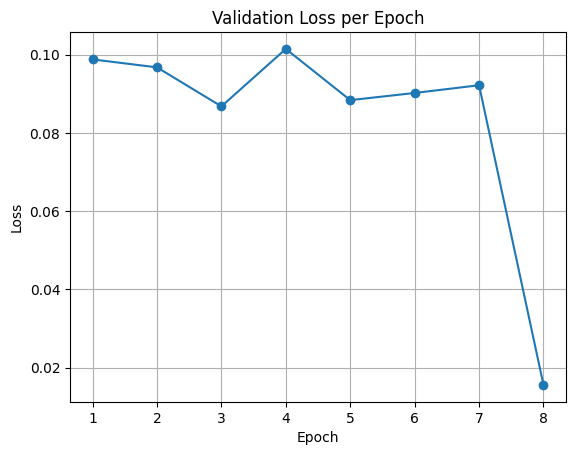

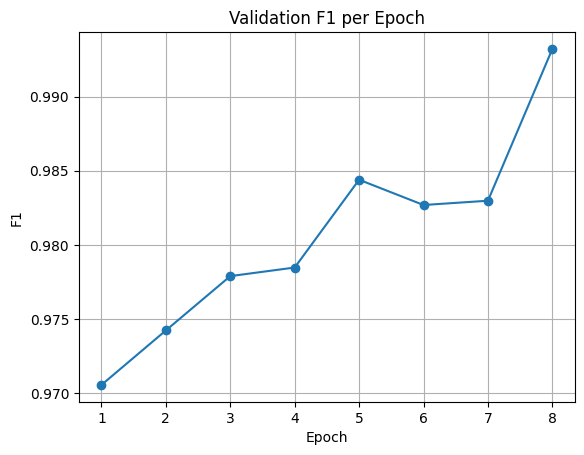

In [6]:

# Evaluasi test set
test_metrics = trainer.evaluate(tokenized_ds["test"])
print("Test metrics:", test_metrics)

# Classification report (per label)
preds_raw, labels_raw, _ = trainer.predict(tokenized_ds["test"])
pred_ids = np.argmax(preds_raw, axis=-1)

true_predictions = []
true_labels = []
for pred, lab in zip(pred_ids, labels_raw):
    curr_pred, curr_lab = [], []
    for p_i, l_i in zip(pred, lab):
        if l_i == -100:
            continue
        curr_pred.append(id2label[p_i])
        curr_lab.append(id2label[l_i])
    true_predictions.append(curr_pred)
    true_labels.append(curr_lab)

print("\nClassification Report (seqeval):")
print(classification_report(true_labels, true_predictions, scheme=IOB2))

# Ambil history training dari trainer.state.log_history
logs = trainer.state.log_history
# Ekstrak loss/eval stats per epoch
epochs = []
train_loss = []
eval_loss = []
eval_f1 = []

for rec in logs:
    if "epoch" in rec:
        ep = rec["epoch"]
        if "loss" in rec:
            epochs.append(ep)
            train_loss.append(rec["loss"])
        if "eval_loss" in rec:
            eval_loss.append(rec["eval_loss"])
        if "eval_f1" in rec:
            eval_f1.append(rec["eval_f1"])

# Plot training loss
plt.figure()
plt.plot(epochs[:len(train_loss)], train_loss, marker="o")
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Plot eval loss
epochs = list(range(1, len(eval_loss) + 1))  # Membuat epochs sesuai dengan panjang eval_loss
plt.plot(epochs, eval_loss, marker="o")
plt.title("Validation Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


# Plot eval F1
plt.figure()
plt.plot(epochs[:len(eval_f1)], eval_f1, marker="o")
plt.title("Validation F1 per Epoch")
plt.xlabel("Epoch")
plt.ylabel("F1")
plt.grid(True)
plt.show()
